In [66]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
from scipy.stats import linregress

from tqdm import tqdm

In [96]:
outpath = "/oak/stanford/groups/horence/JuliaO/visium_analysis/notebooks/output/make_skew_plots/"

In [67]:
dataname = "V1_Mouse_Brain_Sagittal_Posterior"

score = "SpliZ"
score2 = "ge"
# load in samples and scores
samples = pd.read_csv("/oak/stanford/groups/horence/JuliaO/visium_analysis/notebooks/output/make_samplesheet/spatial.csv",index_col = 0)
row = samples.loc[ dataname]

scores = pd.read_csv("/oak/stanford/groups/horence/JuliaO/visium_analysis/notebooks/output/make_samplesheet/scores.csv",index_col=0)
srow = scores.loc[ score]
srow2 = scores.loc[ score2]

# open both dataframes
print(row[srow["valname"]])
df = pd.read_csv(row[srow["valname"]],sep="\t")
print(row[srow2["valname"]])
df2 = pd.read_csv(row[srow2["valname"]],sep="\t")

/oak/stanford/groups/horence/JuliaO/nf-spliz-output/run_dir/visium_2_June_2022/V1_Mouse_Brain_Sagittal_Posterior/SpliZ_values/V1_Mouse_Brain_Sagittal_Posterior_sym_SVD_normdonor_S_0.1_z_0.0_b_5_r_0.01_subcol.tsv
/oak/stanford/groups/horence/JuliaO/visium_analysis/scripts/output/parse_gene_expression/V1_Mouse_Brain_Sagittal_Posterior_sub_1000.tsv


In [68]:
thresh = 100

# subset for number of spots (in score 1 df)
df["num_spots"] = df[srow["genecol"]].map(df.groupby(srow["genecol"])[srow["cellid"]].nunique())
df = df[df["num_spots"] > thresh]

# create column to use to map between scores
df["gene_cell"] = df[srow["genecol"]] + "_" + df[srow["cellid"]]
df2["gene_cell"] = df2[srow2["genecol"]] + "_" + df2[srow2["cellid"]]

# include score2 in score1 df
df[srow2["col"]] = df["gene_cell"].map({x : y for x, y in zip(df2["gene_cell"],df2[srow2["col"]])})

# only include rows where neither score is NA
df = df[(~(df[srow["col"]].isna())) & (~(df[srow2["col"]].isna()))]

In [76]:
cols = [srow["col"],srow2["col"]]
out = {srow["genecol"] : [], "num_spots" : [], "r_squared" : []}

res_map = {}
norm_map = {}
norm_map2 = {}

# get residual for each window
for window, windf in tqdm(df.groupby(srow["genecol"])):
  if window == "Gng13":
    for col in cols:
  #      qval = q
  #      
  #      # quantile
  #      while True:
  #        try:
  #          windf["{}_quant".format(col)] = pd.qcut(windf[col],qval,labels=False)
  #  
  #          break
  #        except:
  #          qval -= 1

      # randomize rows so ties are broken randomly (for ranking)
      windf = windf.sample(frac=1)

      # rank each  value
      windf["{}_quant".format(col)] = windf[col].rank(method="first")

      # inverse cdf to normal
      windf["{}_norm".format(col)] = norm.ppf((windf["{}_quant".format(col)])/(windf["{}_quant".format(col)].max() + 1))

    # perform regression on these values
    result = linregress(windf["{}_norm".format(srow["col"])], windf["{}_norm".format(srow2["col"])])
    out[srow["genecol"]].append(window)
    out["num_spots"].append(windf[srow["cellid"]].nunique())
    out["r_squared"].append(result.rvalue**2)

    # find prediction from regression, and residuals
    windf["predict"] = result.intercept + result.slope*windf["{}_norm".format(srow2["col"])]
    windf["res"] = windf["{}_norm".format(srow["col"])] - windf["predict"]
    norm_map = {**norm_map,**{x : y for x, y in zip(windf["gene_cell"],windf["{}_norm".format(srow["col"])])}}
    norm_map2 = {**norm_map2,**{x : y for x, y in zip(windf["gene_cell"],windf["{}_norm".format(srow2["col"])])}}

    res_map = {**res_map,**{x : y for x, y in zip(windf["gene_cell"],windf["res"])}}
    break

 27%|██▋       | 29/108 [00:00<00:00, 1586.16it/s]


In [77]:
window

'Gng13'

In [83]:
cols[0]

'scZ'

In [97]:
def plot_cols(xcol,ycol,windf):
  plt.plot(windf[xcol],windf[ycol],marker="o",linestyle="",alpha = 0.4)
  plt.title("correlation: {:0.3f}".format(windf[xcol].corr(windf[ycol])))
  plt.xlabel(xcol)
  plt.ylabel(ycol)
  plt.savefig("{}{}_{}_plot.png".format(outpath,xcol,ycol))
  plt.show()

In [98]:
def plot_hist(col,windf):
  plt.hist(windf[col])
  plt.title(col)
  plt.savefig("{}{}_hist.png".format(outpath,col))
  plt.show()

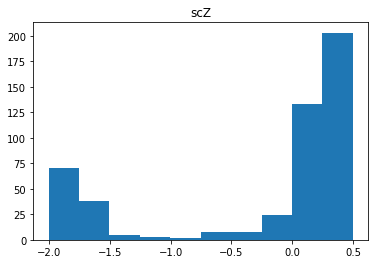

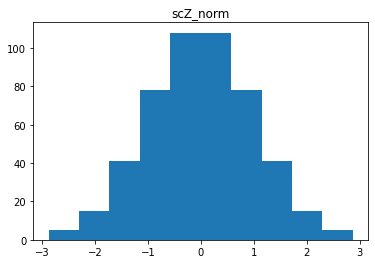

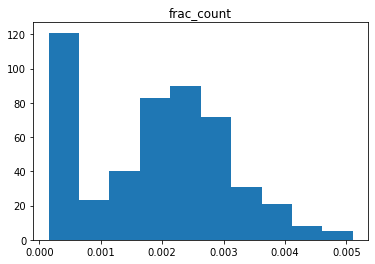

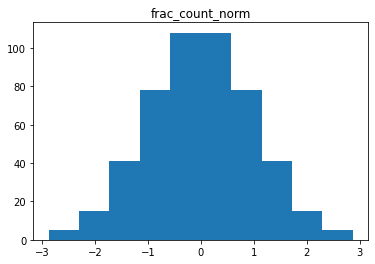

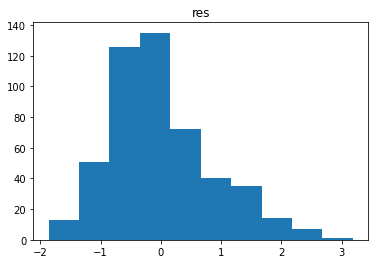

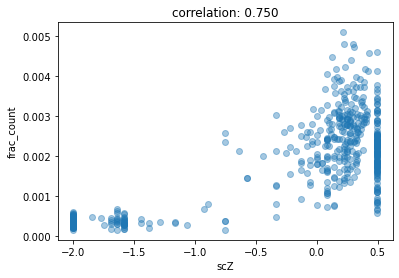

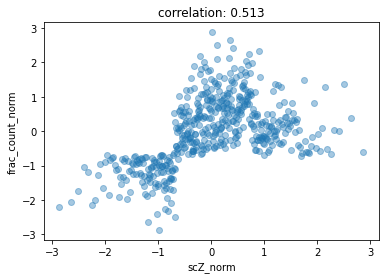

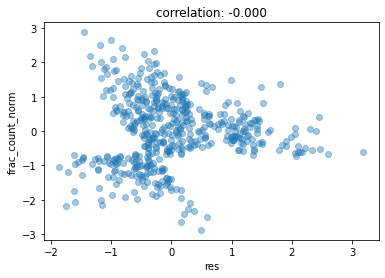

In [99]:
for col in cols:
  plot_hist(col,windf)
  plot_hist(col + "_norm",windf)

plot_hist("res",windf)

plot_cols(cols[0],cols[1],windf)
plot_cols(cols[0] + "_norm",cols[1] + "_norm",windf)
plot_cols("res",cols[1] + "_norm",windf)

In [86]:
windf["res"].corr(windf[cols[1] + "_norm"])


-3.638635488584348e-17

0.7112035092303098

In [22]:
df = pd.read_parquet("/oak/stanford/groups/horence/JuliaO/visium_analysis/scripts/output/readzs_ge/p20190_s003_3_BrainMetastasis_readzs_ge_100.pq")

In [29]:
windf = df[df["window"]== "chr4_36952_minus"]

In [35]:
windf["test"] = [0 for i in range(windf.shape[0])]

/home/users/jolivier/.local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [42]:
windf.sample(frac=1,inplace=True)

TypeError: sample() got an unexpected keyword argument 'inplace'

In [43]:
windf.shape

(31, 20)

In [39]:
windf["test"].rank(method="first")

525        1.0
3035       2.0
3401       3.0
9647       4.0
17408      5.0
22423      6.0
26691      7.0
29173      8.0
31066      9.0
32755     10.0
39235     11.0
39946     12.0
41917     13.0
45929     14.0
48296     15.0
55128     16.0
55473     17.0
57468     18.0
62296     19.0
64853     20.0
68007     21.0
71353     22.0
76882     23.0
77762     24.0
81198     25.0
81519     26.0
102652    27.0
107902    28.0
111844    29.0
115552    30.0
116154    31.0
Name: test, dtype: float64

In [36]:
q = windf.shape[0]
display(windf.shape)
pd.qcut(windf["test"],q,labels=False)

(31, 20)

ValueError: Bin edges must be unique: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]).
You can drop duplicate edges by setting the 'duplicates' kwarg

In [5]:
df["cell_window"] = df["cell_id"] + "_" + df["window"]

In [12]:
vc = temp["window"].value_counts()

In [21]:
temp.drop("count",axis=1)

,cell_id,chr,pos,strand,sample,window,window_count,cell_count,frac_count,barcode,in_tissue,array_row,array_col,xcoord,ycoord,plot_xcoord,plot_ycoord,pixval,pixquant,cell_window
0,p20190_s003_3_BrainMetastasis_ACAAGGAAATCCGCCC,chr2,3580026,+,p20190_s003_3_BrainMetastasis,chr2_717_plus,629,14757,0.000068,ACAAGGAAATCCGCCC-1,1,49,75,8131,8116,-8131,8116,88,8,p20190_s003_3_BrainMetastasis_ACAAGGAAATCCGCCC...
10,p20190_s003_3_BrainMetastasis_ACAAGGAAATCCGCCC,chr2,28800897,+,p20190_s003_3_BrainMetastasis,chr2_5761_plus,114,14757,0.000068,ACAAGGAAATCCGCCC-1,1,49,75,8131,8116,-8131,8116,88,8,p20190_s003_3_BrainMetastasis_ACAAGGAAATCCGCCC...
14,p20190_s003_3_BrainMetastasis_ACAAGGAAATCCGCCC,chr2,32916235,+,p20190_s003_3_BrainMetastasis,chr2_6584_plus,706,14757,0.000068,ACAAGGAAATCCGCCC-1,1,49,75,8131,8116,-8131,8116,88,8,p20190_s003_3_BrainMetastasis_ACAAGGAAATCCGCCC...
19,p20190_s003_3_BrainMetastasis_ACAAGGAAATCCGCCC,chr2,46386573,+,p20190_s003_3_BrainMetastasis,chr2_9278_plus,126,14757,0.000068,ACAAGGAAATCCGCCC-1,1,49,75,8131,8116,-8131,8116,88,8,p20190_s003_3_BrainMetastasis_ACAAGGAAATCCGCCC...
20,p20190_s003_3_BrainMetastasis_ACAAGGAAATCCGCCC,chr2,54669439,+,p20190_s003_3_BrainMetastasis,chr2_10934_plus,126,14757,0.000068,ACAAGGAAATCCGCCC-1,1,49,75,8131,8116,-8131,8116,88,8,p20190_s003_3_BrainMetastasis_ACAAGGAAATCCGCCC...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499677,p20190_s003_3_BrainMetastasis_GACGTGTAGGGATTAT,chrM,9743,+,p20190_s003_3_BrainMetastasis,chrM_2_plus,351203,3,0.333333,GACGTGTAGGGATTAT-1,1,28,32,5261,4744,-5261,4744,64,5,p20190_s003_3_BrainMetastasis_GACGTGTAGGGATTAT...
499678,p20190_s003_3_BrainMetastasis_CCTGTCGTGTATGAAG,chrM,7249,+,p20190_s003_3_BrainMetastasis,chrM_2_plus,351203,2,0.500000,CCTGTCGTGTATGAAG-1,1,70,8,10995,2856,-10995,2856,79,7,p20190_s003_3_BrainMetastasis_CCTGTCGTGTATGAAG...
499680,p20190_s003_3_BrainMetastasis_AGAAGAGCGCCGTTCC,chrM,9005,+,p20190_s003_3_BrainMetastasis,chrM_2_plus,351203,1,1.000000,AGAAGAGCGCCGTTCC-1,1,38,88,6630,9137,-6630,9137,38,1,p20190_s003_3_BrainMetastasis_AGAAGAGCGCCGTTCC...
499681,p20190_s003_3_BrainMetastasis_TCGCGTAGCAGTGTCC,chrM,9752,+,p20190_s003_3_BrainMetastasis,chrM_2_plus,351203,6,0.166667,TCGCGTAGCAGTGTCC-1,1,57,99,9225,9999,-9225,9999,45,2,p20190_s003_3_BrainMetastasis_TCGCGTAGCAGTGTCC...


(array([1.285e+03, 7.800e+01, 1.700e+01, 6.000e+00, 5.000e+00, 5.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 5.000e+00]),
 array([   7. ,  211.5,  416. ,  620.5,  825. , 1029.5, 1234. , 1438.5,
        1643. , 1847.5, 2052. ]),
 <BarContainer object of 10 artists>)

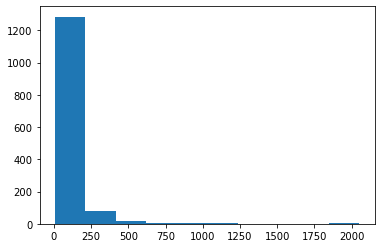

In [15]:
plt.hist(vc)

In [18]:
temp[temp["window"].isin(vc[vc > 100].index)]

,cell_id,chr,pos,strand,count,sample,window,window_count,cell_count,frac_count,...,in_tissue,array_row,array_col,xcoord,ycoord,plot_xcoord,plot_ycoord,pixval,pixquant,cell_window
0,p20190_s003_3_BrainMetastasis_ACAAGGAAATCCGCCC,chr2,3580026,+,1,p20190_s003_3_BrainMetastasis,chr2_717_plus,629,14757,0.000068,...,1,49,75,8131,8116,-8131,8116,88,8,p20190_s003_3_BrainMetastasis_ACAAGGAAATCCGCCC...
14,p20190_s003_3_BrainMetastasis_ACAAGGAAATCCGCCC,chr2,32916235,+,1,p20190_s003_3_BrainMetastasis,chr2_6584_plus,706,14757,0.000068,...,1,49,75,8131,8116,-8131,8116,88,8,p20190_s003_3_BrainMetastasis_ACAAGGAAATCCGCCC...
22,p20190_s003_3_BrainMetastasis_ACAAGGAAATCCGCCC,chr2,55235022,+,1,p20190_s003_3_BrainMetastasis,chr2_11048_plus,1571,14757,0.000068,...,1,49,75,8131,8116,-8131,8116,88,8,p20190_s003_3_BrainMetastasis_ACAAGGAAATCCGCCC...
41,p20190_s003_3_BrainMetastasis_ACAAGGAAATCCGCCC,chr2,84906413,+,1,p20190_s003_3_BrainMetastasis,chr2_16982_plus,5135,14757,0.000068,...,1,49,75,8131,8116,-8131,8116,88,8,p20190_s003_3_BrainMetastasis_ACAAGGAAATCCGCCC...
73,p20190_s003_3_BrainMetastasis_ACAAGGAAATCCGCCC,chr2,97647869,+,1,p20190_s003_3_BrainMetastasis,chr2_19530_plus,504,14757,0.000068,...,1,49,75,8131,8116,-8131,8116,88,8,p20190_s003_3_BrainMetastasis_ACAAGGAAATCCGCCC...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499677,p20190_s003_3_BrainMetastasis_GACGTGTAGGGATTAT,chrM,9743,+,1,p20190_s003_3_BrainMetastasis,chrM_2_plus,351203,3,0.333333,...,1,28,32,5261,4744,-5261,4744,64,5,p20190_s003_3_BrainMetastasis_GACGTGTAGGGATTAT...
499678,p20190_s003_3_BrainMetastasis_CCTGTCGTGTATGAAG,chrM,7249,+,1,p20190_s003_3_BrainMetastasis,chrM_2_plus,351203,2,0.500000,...,1,70,8,10995,2856,-10995,2856,79,7,p20190_s003_3_BrainMetastasis_CCTGTCGTGTATGAAG...
499680,p20190_s003_3_BrainMetastasis_AGAAGAGCGCCGTTCC,chrM,9005,+,1,p20190_s003_3_BrainMetastasis,chrM_2_plus,351203,1,1.000000,...,1,38,88,6630,9137,-6630,9137,38,1,p20190_s003_3_BrainMetastasis_AGAAGAGCGCCGTTCC...
499681,p20190_s003_3_BrainMetastasis_TCGCGTAGCAGTGTCC,chrM,9752,+,1,p20190_s003_3_BrainMetastasis,chrM_2_plus,351203,6,0.166667,...,1,57,99,9225,9999,-9225,9999,45,2,p20190_s003_3_BrainMetastasis_TCGCGTAGCAGTGTCC...


In [8]:
temp = df.drop_duplicates(["cell_id","window"])

In [10]:
temp["cell_window"].value_counts()

p20190_s003_3_BrainMetastasis_ACAAGGAAATCCGCCC_chr2_717_plus        1
p20190_s003_3_BrainMetastasis_CGCGACCGCGACAGAT_chr3_19324_minus     1
p20190_s003_3_BrainMetastasis_GCTAGTAGAGCTTGTA_chr17_16374_minus    1
p20190_s003_3_BrainMetastasis_GCTAGTAGAGCTTGTA_chr17_15156_minus    1
p20190_s003_3_BrainMetastasis_GCTAGTAGAGCTTGTA_chr17_15034_minus    1
                                                                   ..
p20190_s003_3_BrainMetastasis_GGTGGGATTAGGTCCC_chr19_2914_minus     1
p20190_s003_3_BrainMetastasis_GGTGGGATTAGGTCCC_chr19_1705_minus     1
p20190_s003_3_BrainMetastasis_GGTGGGATTAGGTCCC_chr19_1139_minus     1
p20190_s003_3_BrainMetastasis_GGTGGGATTAGGTCCC_chr19_890_minus      1
p20190_s003_3_BrainMetastasis_TCGCGTAGCAGTGTCC_chrM_3_plus          1
Name: cell_window, Length: 131163, dtype: int64

In [18]:
dataname = "p20190_s003_3_BrainMetastasis" 
thresh = 100
samples = pd.read_csv("output/make_samplesheet/spatial.csv",index_col = 0)
row = samples.loc[dataname]

# load counts file
df = pd.read_csv(row["readzs_counts"],sep="\t",header=None)
df.rename(columns={0 : "cell_id",1  : "chr", 2 : "pos", 3 : "strand", 4 : "count", 5 : "sample", 6 : "window"},inplace=True)
print("1 df",df.shape)

# read in ReadZS zscore file
readzs = pd.read_csv(row["readzs_vals"],sep="\t")
print("readzs",readzs.shape)

# only include counts that a z score was calculated for
df = df[df["window"].isin(set(readzs["window"].unique()))]
print("2 df",df.shape)

# get the number of counts of each window
df["window_count"] = df["window"].map(df.groupby("window")["count"].sum())

# subset to windows with counts > thresh
df = df[df["window_count"] > thresh]
print("3 df",df.shape)

# find the count across all windows for each cell
df["cell_count"] = df["cell_id"].map(df.groupby("cell_id")["count"].sum())

# find the fraction of each window in each cell
df["frac_count"] = df["count"]/df["cell_count"]

# merge with metadata
meta = pd.read_csv(row["metadata"],sep="\t")

1 df (2054192, 7)
readzs (763714, 17)
2 df (1973456, 7)
3 df (1570240, 8)


In [19]:
row["metadata"]

'/oak/stanford/groups/horence/JuliaO/visium_analysis/notebooks/output/visium_meta/meta_p20190_s003_3_BrainMetastasis.tsv'

In [20]:
len(set(meta["cell_id"]).intersection(set(df["cell_id"])))

2059